## Writeup Template

---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
def plot_image(image, title):
    f, (ax1) = plt.subplots(1, 1, figsize=(8, 3))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title(title, fontsize=50)
    plt.show()

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

In [3]:
def undistort_init():
    chessboard_images = os.listdir("camera_cal/")

    # Chessboard corners in x and y direction
    nx = 9
    ny = 6

    obj_points = []
    img_points = []

    obj_p = np.zeros((nx * ny, 3), np.float32)
    obj_p[:, :2] = np.mgrid[0: nx, 0: ny].T.reshape(-1, 2)

    # Find chessboard corners
    for image_file in chessboard_images: 
        image = cv2.imread(os.path.join("camera_cal", image_file))  
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
            img_points.append(corners)
            obj_points.append(obj_p)

    # Calibrate and undistort the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1],None,None)
    
    return mtx, dist

def undistort(test_image, mtx, dist):
    undist = cv2.undistort(test_image, mtx, dist, None, mtx)
    return undist
    

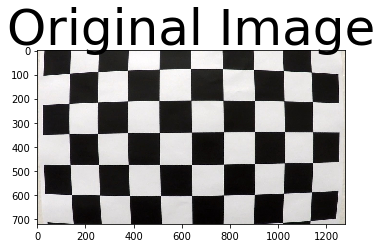

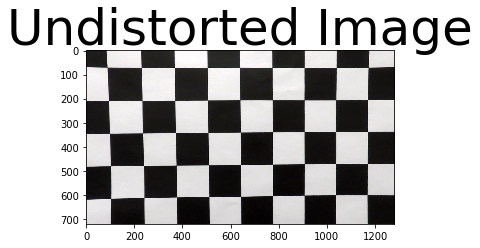

In [4]:
image = cv2.imread('camera_cal/calibration1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mtx, dist = undistort_init()
undist = undistort(image, mtx, dist)
    
plot_image(image, 'Original Image')
plot_image(undist, 'Undistorted Image')

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:

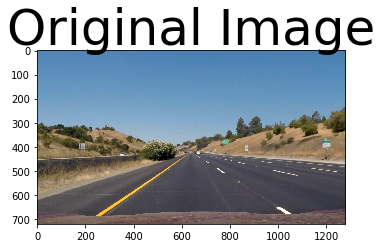

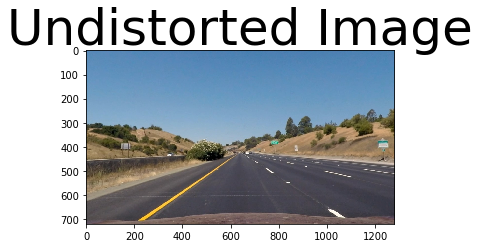

In [5]:
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mtx, dist = undistort_init()
undist = undistort(image, mtx, dist)
    
plot_image(image, 'Original Image')
plot_image(undist, 'Undistorted Image')

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I used a combination of color and gradient thresholds to generate a binary image. By manually changing the thresholds I found a good set to create a binary image (combined from different ways of doing so). I also used the S-Channel of the HLS representation of the image to get a better saturated binary image.

In [6]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def hls_select(img, thresh=(0, 255)):    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = img[:,:,2]        
    binary_output = np.zeros_like(gray)
    binary_output[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    return binary_output

def hsv_select(img, thresh=(0, 255)):    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    gray = img[:,:,2]        
    binary_output = np.zeros_like(gray)
    binary_output[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    return binary_output

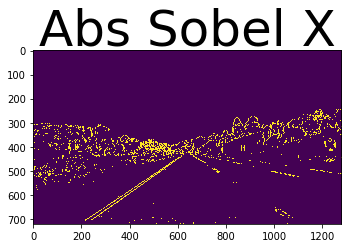

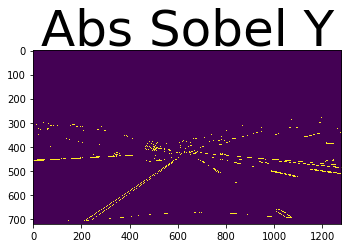

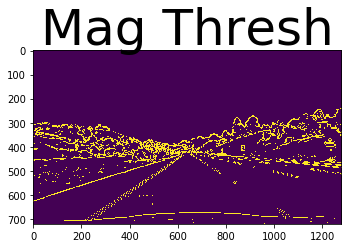

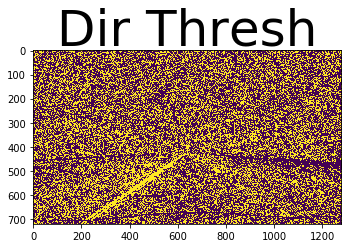

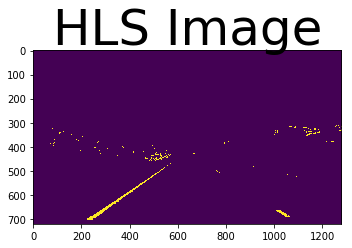

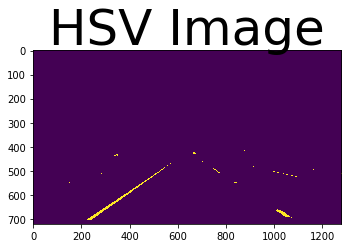

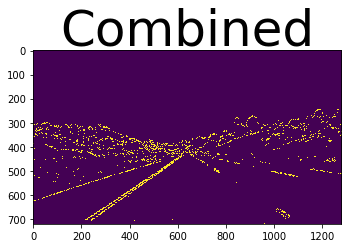

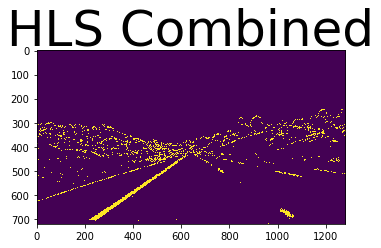

In [7]:
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mtx, dist = undistort_init()
undist = undistort(image, mtx, dist)
    
abs_sobel_x = abs_sobel_thresh(undist, orient='x', thresh_min=20, thresh_max=115)
abs_sobel_y = abs_sobel_thresh(undist, orient='y', thresh_min=70, thresh_max=255)
mag_thresh_img = mag_thresh(undist, sobel_kernel=9, mag_thresh=(35, 100))
dir_thresh_img = dir_threshold(undist, sobel_kernel=7, thresh=(0.7, 1.3))
hls_image = hls_select(undist, (160, 255))
hsv_image = hsv_select(undist, (225, 255))

combined = np.zeros_like(abs_sobel_x)
combined[((abs_sobel_x == 1) & (abs_sobel_y == 1)) | ((mag_thresh_img == 1) & (dir_thresh_img == 1))] = 1

binary_image = np.zeros_like(combined)
binary_image[(combined == 1) | (hls_image == 1)] = 1

plot_image(abs_sobel_x, 'Abs Sobel X')
plot_image(abs_sobel_y, 'Abs Sobel Y')
plot_image(mag_thresh_img, 'Mag Thresh')
plot_image(dir_thresh_img, 'Dir Thresh')
plot_image(hls_image, 'HLS Image')
plot_image(hsv_image, 'HSV Image')
plot_image(combined, 'Combined')
plot_image(binary_image, 'HLS Combined')

In [8]:
def create_binary(image):
    abs_sobel_x = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=115)
    abs_sobel_y = abs_sobel_thresh(image, orient='y', thresh_min=70, thresh_max=255)
    mag_thresh_img = mag_thresh(image, sobel_kernel=9, mag_thresh=(35, 100))
    dir_thresh_img = dir_threshold(image, sobel_kernel=7, thresh=(0.7, 1.3))
    hls_image = hls_select(image, (170, 255))
    hsv_image = hsv_select(image, (225, 255))

    combined = np.zeros_like(abs_sobel_x)
    # combined[(hls_image == 1) | (((abs_sobel_x == 1) & (abs_sobel_y == 1)) | ((mag_thresh_img == 1) & (dir_thresh_img == 1)))] = 1
    combined[(hls_image == 1) | (((abs_sobel_x == 1) & (abs_sobel_y == 1)) | ((mag_thresh_img == 1) & (dir_thresh_img == 1)))] = 1

    
    # color_binary = np.dstack(( combined, combined, combined)) * 255
    
    return combined

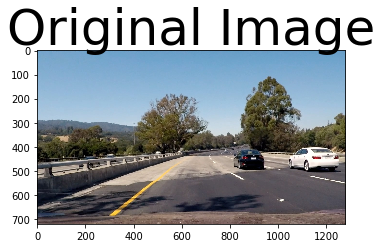

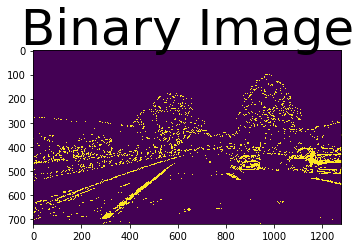

In [9]:
image = cv2.imread('test_images/test4.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mtx, dist = undistort_init()
undist = undistort(image, mtx, dist)
binary_image = create_binary(undist)
    
plot_image(image, 'Original Image')
plot_image(binary_image, 'Binary Image')

#### Before warping the image I calculate a region of interest (the same way as in the first project) to minimize the false positive lane-lines

In [55]:
def region_of_interest(img, vertices=np.array([[(180, 670),(620, 420), (640, 420), (420,670), (1000,670), (640,420), (660,420),(1200,670)]], dtype=np.int32)):
    mask = np.zeros_like(img)   
    # vertices = np.array([[(180, 670),(600, 420), (710, 420), (1100,670)]], dtype=np.int32)
    # vertices = np.array([[(180, 670),(620, 420), (640, 420), (420,670), (1000,670), (640,420), (660,420),(1200,670)]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, (255,255,255))
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

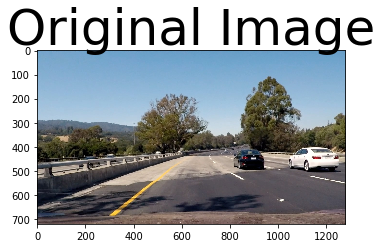

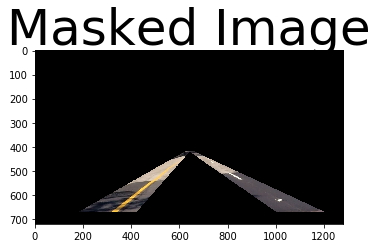

In [38]:
image = cv2.imread('test_images/test4.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mtx, dist = undistort_init()
undist = undistort(image, mtx, dist)
binary_image = create_binary(undist)
masked_image = region_of_interest(image)
    
plot_image(image, 'Original Image')
plot_image(masked_image, 'Masked Image')

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

In the warp function I warp the image to birds-eye view with the following src and dst points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 535, 491      | 400, 0        | 
| 750, 491      | 880, 0        |
| 1050, 670     | 880, 720      |
| 250, 670      | 400, 720      |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

In [39]:
def warp(image, show=False):
    h,w = image.shape[:2]
    offset = 380
    src = np.float32([(535,491),
                      (750,491),
                      (1050,670),
                      (250,670)])
    dst = np.float32([(offset,0),
                      (w-offset,0),
                      (w-offset,h),
                      (offset,h)])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, (w,h), flags=cv2.INTER_LINEAR)
    
    if show:
        srcx = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
        srcy = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
        dstx = [dst[0][0],dst[1][0],dst[2][0],dst[3][0],dst[0][0]]
        dsty = [dst[0][1],dst[1][1],dst[2][1],dst[3][1],dst[0][1]]
        
        # Show the result on one image
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=50)
        ax1.plot(srcx, srcy, color='#ff0000', alpha=0.9, linewidth=3, solid_capstyle='round', zorder=2)

        ax2.imshow(warped)
        ax2.set_title('Warped Image', fontsize=50)
        ax2.plot(dstx, dsty, color='#ff0000', alpha=0.9, linewidth=3, solid_capstyle='round', zorder=2)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return warped, Minv

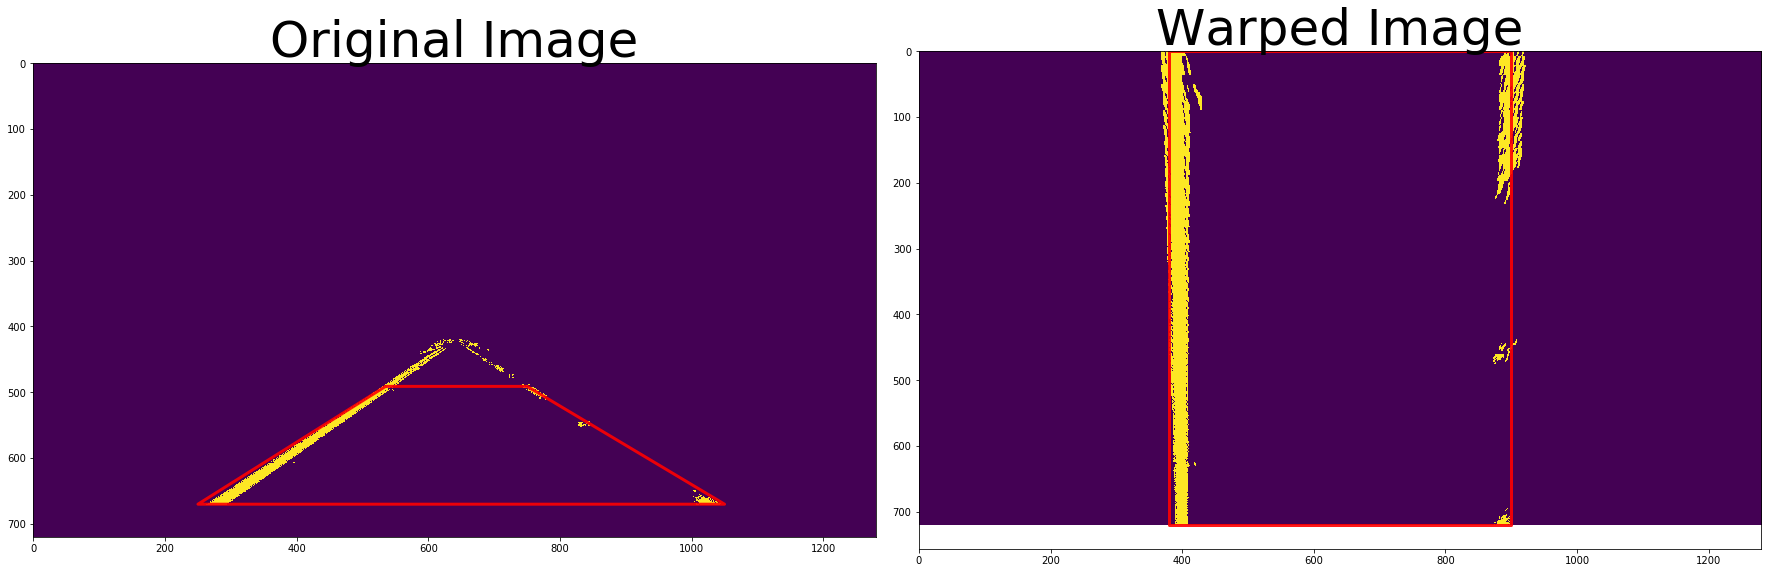

In [40]:
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mtx, dist = undistort_init()
undist = undistort(image, mtx, dist)
binary_image = create_binary(undist)
masked_image = region_of_interest(binary_image)
warped, Minv = warp(masked_image, True)

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

I used the histogram peaks to find the lane lines in the binary warped image, with the code below.

In [41]:
def line_fitting(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin        
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )    
    
    # Here I fit the lane-line pixels with the polynomial
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, left_fit, right_fit, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds

def continuous_lane_fitting(binary_warped, left_fit_prev, right_fit_prev):
    out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Here I fit the lane-line pixels with the polynomial
    left_fitx = left_fit_prev[0]*ploty**2 + left_fit_prev[1]*ploty + left_fit_prev[2]
    right_fitx = right_fit_prev[0]*ploty**2 + right_fit_prev[1]*ploty + right_fit_prev[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, left_fit, right_fit, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds

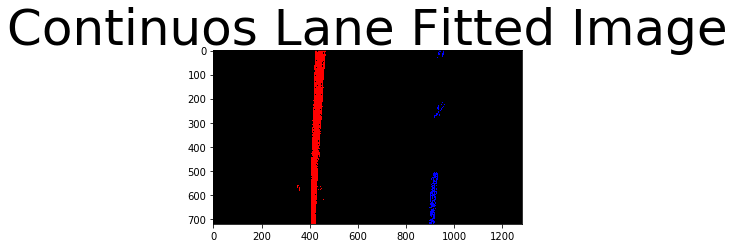

In [42]:
image = cv2.imread('test_images/test3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mtx, dist = undistort_init()
undist = undistort(image, mtx, dist)
binary_image = create_binary(undist)
masked_image = region_of_interest(binary_image)
warped, Minv = warp(masked_image, False)
lane_fitted, left_fit, right_fit, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds = line_fitting(warped)
continuous_lane_fitted, left_fit, right_fit, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds = continuous_lane_fitting(warped, left_fit, right_fit)
plot_image(continuous_lane_fitted, 'Continuos Lane Fitted Image')

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In [43]:
def measure_curvature_pixels(left_fit, right_fit, ploty):
    y_eval = np.max(ploty)    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def measure_curvature_real(leftx, rightx, ploty):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

def center(left_fit, right_fit, width, height):
    car_position = width / 2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    l_fit_x_int = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
    r_fit_x_int = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center_dist = (car_position - lane_center_position) * xm_per_pix
    return center_dist

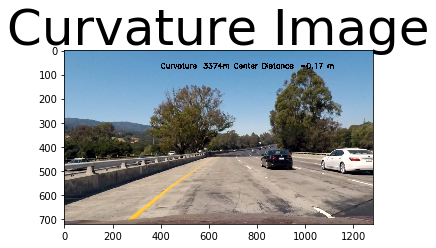

In [44]:
image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mtx, dist = undistort_init()
undist = undistort(image, mtx, dist)
binary_image = create_binary(undist)
masked_image = region_of_interest(binary_image)
warped, Minv = warp(masked_image, False)
lane_fitted, left_fit, right_fit, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds = line_fitting(warped)

left_curverad, right_curverad = measure_curvature_pixels(left_fit, right_fit, ploty)
left_curverad_real, right_curverad_real = measure_curvature_real(left_fitx, right_fitx, ploty)

height, width = lane_fitted.shape[:2]
center_distance = center(left_fit, right_fit, width, height)

real_curvature = int((left_curverad_real + right_curverad_real) / 2)
string_builder = "Curvature: {}m ".format(real_curvature) + "Center Distance: {0:.2f} m".format(center_distance)
cv2.putText(undist, string_builder, (400,75), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 3)

plot_image(undist, 'Curvature Image')

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

In [45]:
def plot_lane(binary_warped, undist, Minv, ploty, left_fit, right_fit):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result  

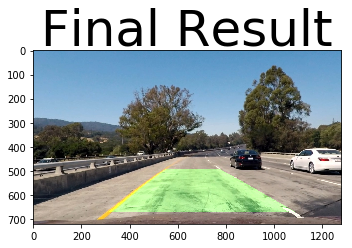

In [46]:
image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mtx, dist = undistort_init()
undist = undistort(image, mtx, dist)
binary_image = create_binary(undist)
masked_image = region_of_interest(binary_image)
warped, Minv = warp(masked_image, False)
lane_fitted, left_fit, right_fit, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds  = line_fitting(warped)
result = plot_lane(warped, undist, Minv, ploty, left_fit, right_fit)

plot_image(result, "Final Result")

### Pipeline (video)

In [58]:
def process_image(image):
    undist = undistort(image, mtx, dist)
    binary_image = create_binary(undist)
    
    vertices = np.array([[(180, 670),(620, 420), (640, 420), (420,670), (1000,670), (640,420), (660,420),(1200,670)]], dtype=np.int32)
    masked_image = region_of_interest(binary_image, vertices)
    warped, Minv = warp(masked_image, False)        
    lane_fitted, left_fit, right_fit, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds = line_fitting(warped)
    
    output = plot_lane(warped, undist, Minv, ploty, left_fit, right_fit)
    left_curverad, right_curverad = measure_curvature_pixels(left_fit, right_fit, ploty)
    left_curverad_real, right_curverad_real = measure_curvature_real(left_fitx, right_fitx, ploty)
    height, width = lane_fitted.shape[:2]
    center_distance = center(left_fit, right_fit, width, height)
    
    #print(left_curverad_real, right_curverad_real)
    left_lane = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
    right_lane = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]
    lane_distance = np.abs(left_lane - right_lane)
    # print(lane_distance, left_lane, right_lane)

    real_curvature = int((left_curverad_real + right_curverad_real) / 2)
    string_builder = "Curvature: {}m ".format(real_curvature) + "Center Distance: {0:.2f} m".format(center_distance)
    # string_builder = "Left: {} m".format(left_curverad_real) + "Right: {} m".format(right_curverad_real) 
    
    result = plot_lane(warped, undist, Minv, ploty, left_fit, right_fit)
    cv2.putText(result, string_builder, (400,75), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 3)   

    return result
    
     
        
    


In [59]:
# Process pipeline with aditional information
def process_image_ex(image):
    undist = undistort(image, mtx, dist)
    binary_image = create_binary(undist)
    
    vertices = np.array([[(180, 670),(620, 420), (640, 420), (420,670), (1000,670), (640,420), (660,420),(1200,670)]], dtype=np.int32)

    
    masked_image = region_of_interest(binary_image, vertices)
    warped, Minv = warp(masked_image, False)        
    lane_fitted, left_fit, right_fit, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds = line_fitting(warped)
    
    output = plot_lane(warped, undist, Minv, ploty, left_fit, right_fit)

    output1 = cv2.resize(masked_image,(640, 360), interpolation = cv2.INTER_AREA)
    output2 = cv2.resize(lane_fitted,(640, 360), interpolation = cv2.INTER_AREA)

    # Create an array big enough to hold both images next to each other.
    vis = np.zeros((720, 1280+640, 3))
    
    string_builder = "{}".format(np.average(left_lane_inds))
    cv2.putText(output, string_builder, (25,75), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3) 
    string_builder = "{}".format(np.average(right_lane_inds))
    cv2.putText(output, string_builder, (25,125), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3) 

    output1 = np.dstack(( output1, output1, output1)) * 255
    # Copy both images into the composed image.
    vis[:720, :1280,:] = output
    vis[:360, 1280:1920,:] = output1
    vis[360:720, 1280:1920,:] = output2

    return vis

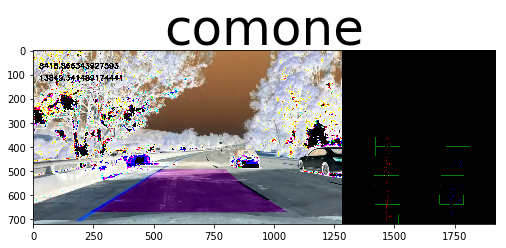

In [52]:
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = process_image_ex(image)
plot_image(result, 'comone')

In [60]:
# chosen_video = 'challenge_video'
chosen_video = 'project_video'

mtx, dist = undistort_init()

video_output1 = chosen_video + '_output.mp4'
video_input1 = VideoFileClip(chosen_video + '.mp4')
# processed_video = video_input1.fl_image(process_image_ex)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [09:37<00:00,  2.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 6min 39s, sys: 1.03 s, total: 6min 40s
Wall time: 9min 40s


### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

The biggest issue I faced was deciding on how to create the binary image. There are many different ways and a lot of possible combinations, therefore a good combination was hasrd to find. 

The pipeline will most likely fail if there are multiple lanes in the region of interest. Due to the region of interest only being around the left and right lane, narrow lane lines or wi Also if there are different light conditions (going from a very bright road to a darker road in the shadows, or the other way around) can result in bad lane finding.

An improvement could be to always consider the last few frames to improve the robustness.